## For N=7


In [2]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import copy

In [3]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available.")
device = torch.device("cuda:0")
print(f"Running on GPU: {torch.cuda.get_device_name(0)}")

Running on GPU: NVIDIA A100-PCIE-40GB


In [4]:
# Cell 2: SquareEITNN Class
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n ** 2 + 8 * self.n
        self.output_size = self.n ** 2 + 4 * self.n
        self.interior_size = self.n ** 2
        self.neumann_copy_start = self.n ** 2 + 4 * self.n

        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False)).to(device)
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64).to(device)
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool).to(device)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False

        self.W1__grad = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False).to(device)
        self.W2__grad = torch.zeros(self.output_size, self.hidden_size, dtype=torch.float64, requires_grad=False).to(device)
        self._initialize_W1_blocks()
        self._initialize_W2()

    def assign_gradients(self, x_data, h, y, alpha):
        with torch.no_grad():
            batch_size = y.shape[0]
            dL_dy = torch.zeros_like(y).to(device)
            dL_dy[:, :self.n**2] = alpha * y[:, :self.n**2] / batch_size
            dL_dy[:, self.n**2:] = y[:, self.n**2:] / batch_size

            dW2 = dL_dy.T @ h
            grad = {}
            w2_indices = [(i, j) for i in range(self.n**2) for j in self.grid.get_node_by_index(i).neighbors if i < j < self.interior_size + 4*self.n]
            for i, j in w2_indices:
                grad[(i, j)] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]
                self.W2__grad[i, j] = grad[(i, j)] / (1 + self.Beta[i, j]**2)

            dW1 = self.W2_dynamic.T @ dL_dy.T @ x_data
            for i in range(self.n**2):
                for j in range(4*self.n):
                    self.W1__grad[i, j] = dW1[i, j]

    def _initialize_W1_blocks(self):
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n, dtype=torch.float64).to(device)
            self.W1[:self.interior_size, 4*self.n:] = 0.0
            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(device)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(device)
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(device)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(device)

    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size
        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad=False)).to(device)
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64).to(device)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool).to(device)

        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64)).to(device)
                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    self.Beta[j, i] = weights[k]
                    self.W2_fixed[j, i] = weights[k]
                    self.W2_mask[i, j] = False
                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size + 4*self.n):
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(device))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(device))

            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0

    def symmetrize_W2_after_training(self):
        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                for k, j in enumerate(neighbor_indices):
                    self.W2_fixed[i,j] = self.transform(self.Beta[i,j])
                    self.W2_fixed[j,i] = self.transform(self.Beta[i,j])
            for i in range(self.interior_size + 4*self.n):
                self.W2_fixed[i, i] = 0
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(device))

    def transform(self, x):
        return torch.arctan(x) + torch.pi/2

    def forward(self, x):
        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1).to(device)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta) + torch.pi/2).to(device)
        hid = torch.matmul(x, self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        return outp, hid


In [5]:
# Cell 3: Helper Functions
def generate_dtn_data(grid, batch_size):
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)

    for k in range(min(batch_size, 4*grid.n)):            
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)
    return data

def loss_function(output, grid, alpha=1.0):
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n].to(device)
    boundary = output[:, -4*grid.n:].to(device)
    interior_loss = alpha * torch.sum(interior ** 2) / (2 * batch_size)
    boundary_loss = torch.sum(boundary ** 2) / (2 * batch_size)
    total_loss = interior_loss + boundary_loss
    return total_loss, interior_loss, boundary_loss

def adam_with_grad_clip(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step, max_grad_norm=1.0):
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param).to(device)
        grad_norm = torch.norm(grad, p=2)
        if grad_norm > max_grad_norm:
            grad = grad * max_grad_norm / grad_norm
        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        delta = alpha * m_corr / (torch.sqrt(v_corr) + eps)
        param = param - delta
        return param, m_t1, v_t1

In [6]:
# Cell 4: Custom Scheduler and Training Function
class CustomCosineAnnealingWarmRestarts:
    def __init__(self, T_0, initial_lr, T_mult=1, eta_min=1e-8, eta_max_factor=0.08):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.eta_max_factor = eta_max_factor
        self.t = 0
        self.cycle = 0
        self.T_cur = T_0
        self.base_lr = initial_lr

    def step(self):
        if self.t >= self.T_cur:
            self.cycle += 1
            self.base_lr *= self.eta_max_factor
            self.T_cur = self.T_0 * (self.T_mult ** self.cycle)
            self.t = 0
        lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + np.cos(np.pi * self.t / self.T_cur))
        self.t += 1
        return lr

    def reset(self, new_base_lr):
        self.base_lr = new_base_lr
        self.cycle = 0
        self.T_cur = self.T_0
        self.t = 0

In [7]:
def train_adaptive(num_epochs, dataloader, model, alpha, learning_rate, grid, min_lr=1e-10, eta_max=0.08,
                   beta1=0.9, beta2=0.999, eps=1e-8, patience=7500, init_delta_thresh=1e-4, cycle_length=5000):
    model.to(device)
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    scheduler = CustomCosineAnnealingWarmRestarts(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=min_lr, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    best_lr = learning_rate
    epochs_since_improvement = 0
    beta1_current = beta1
    beta2_current = beta2
    beta_updated = False

    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(output, grid, alpha)

            #assign the gradients manually
            model.assign_gradients(batch_x, hid, output, alpha)

            #update the parameters usign the custom adam optimizer

            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam_with_grad_clip(param, grad, learning_rate, m, v, beta1_current, beta2_current, eps, t, max_grad_norm=1.0)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        #update alpha as time goes on...initially we started with a lower alpha to prioritize boundary loss but as we get better loss, we also 
        # give priority to the interior loss


        min_loss = min(interior_loss_epoch, boundary_loss_epoch)
        if min_loss < 1e-9 and alpha < 1.0:
            alpha = 1.0
        elif min_loss < 1e-8 and alpha < 0.9:
            alpha = 0.9
        elif min_loss < 1e-7 and alpha < 0.8:
            alpha = 0.8

        learning_rate = max(scheduler.step(), min_lr)

        #if the base_learning rate becomes too low, reset the base_learning rate andd restart once
        # in case we are stuck in a local minima, this should help us get out of it

        if scheduler.base_lr < 1e-7 and not beta_updated:
            scheduler.reset(new_base_lr=1e-4)
            learning_rate = scheduler.step()
            beta1_current = 0.95
            beta2_current = 0.9999
            beta_updated = True
            print(f"Epoch [{epoch+1}/{num_epochs}], Resetting Base LR to 1e-4, beta1 to {beta1_current}, beta2 to {beta2_current}")

        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            best_lr = learning_rate
            #reduce the delta_threshold as the training loop progresses
            if best_loss > 0:
                order = np.floor(np.log10(best_loss))
                init_delta_thresh = 1e-4 * 10 ** order
            epochs_since_improvement = 0
        elif best_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (best_loss = 0)")
            break
        else:
            epochs_since_improvement += 1

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Best LR: {best_lr:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}, Delta Thresh: {init_delta_thresh:.6e}, Beta1: {beta1_current:.4f}, Beta2: {beta2_current:.4f}")

        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-12)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    plt.plot(loss_record, label="Total Loss")
    plt.plot(interior_loss_record, label="Interior Loss")
    plt.plot(boundary_loss_record, label="Boundary Loss")
    plt.yscale("log")
    plt.legend()
    plt.savefig("loss_plot.png")
    plt.close()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

In [7]:
torch.manual_seed(42)
n = 7
num_epochs = 30000
batch_size = 32
learning_rate = 0.02
alpha = 0.7
cycle_length = 5000

grid = GridStructure(n)
batch_size = min(4*n, batch_size)
data = generate_dtn_data(grid, batch_size)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid)

Epoch [1000/30000], Total Loss: 1.564737e-02, Interior: 3.307328e-03, Boundary: 1.234004e-02, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.809386e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-06, Beta1: 0.9000, Beta2: 0.9990
Epoch [2000/30000], Total Loss: 4.194006e-03, Interior: 1.083704e-03, Boundary: 3.110302e-03, Alpha: 0.7000, LR: 1.309615e-02, Best LR: 1.309615e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [3000/30000], Total Loss: 2.635099e-03, Interior: 7.331078e-04, Boundary: 1.901992e-03, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 6.915806e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [4000/30000], Total Loss: 2.148548e-03, Interior: 6.179590e-04, Boundary: 1.530589e-03, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 1.913525e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Be

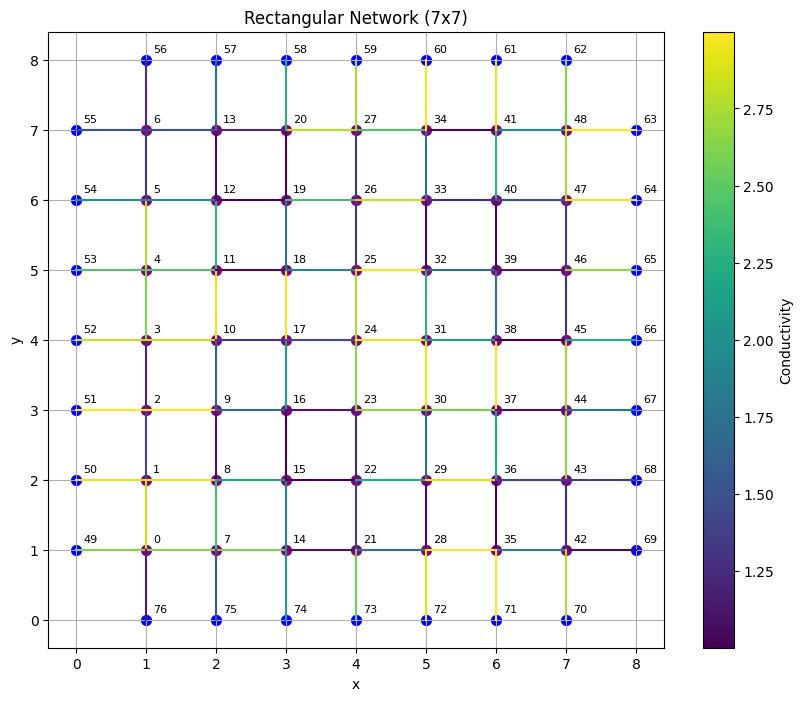

Recovered Conductivity


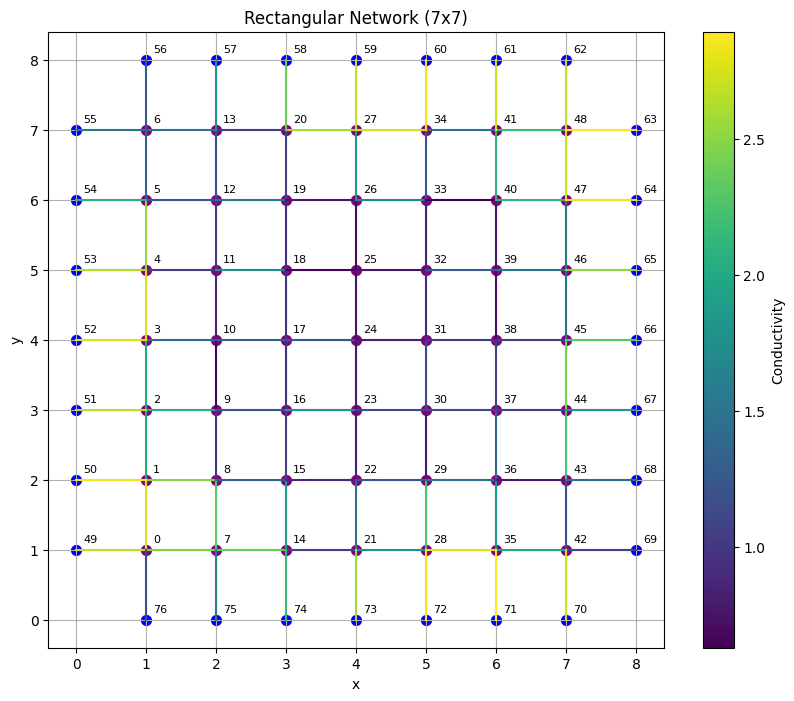

In [8]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_adaptive(
    num_epochs, dataloader, model, alpha, learning_rate, grid,
    min_lr=1e-10, eta_max=0.08, beta1=0.9, beta2=0.999, eps=1e-8,
    patience=1.5*cycle_length, init_delta_thresh=1e-4, cycle_length=cycle_length
)

In [9]:
torch.manual_seed(42)
n = 7
num_epochs = 35000
batch_size = 32
learning_rate = 0.02
alpha = 0.7
cycle_length = 5000

grid = GridStructure(n)
batch_size = min(4*n, batch_size)
data = generate_dtn_data(grid, batch_size)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid)

Epoch [1000/30000], Total Loss: 1.566249e-02, Interior: 3.350714e-03, Boundary: 1.231178e-02, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.809386e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-06, Beta1: 0.9000, Beta2: 0.9990
Epoch [2000/30000], Total Loss: 4.234451e-03, Interior: 1.120492e-03, Boundary: 3.113959e-03, Alpha: 0.7000, LR: 1.309614e-02, Best LR: 1.314987e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [3000/30000], Total Loss: 2.635103e-03, Interior: 7.331086e-04, Boundary: 1.901995e-03, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 6.915806e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [4000/30000], Total Loss: 2.148550e-03, Interior: 6.179594e-04, Boundary: 1.530590e-03, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 1.913525e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Be

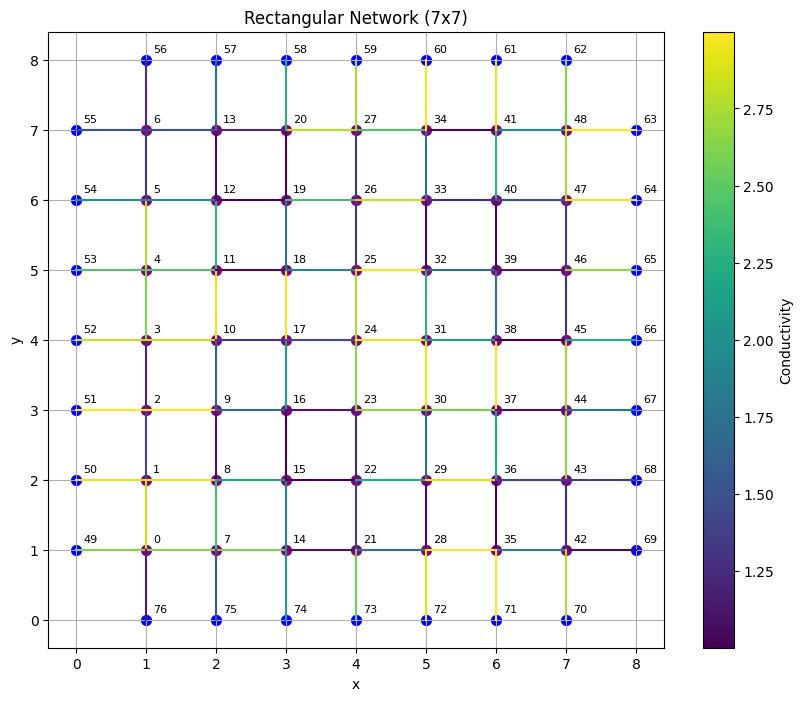

Recovered Conductivity


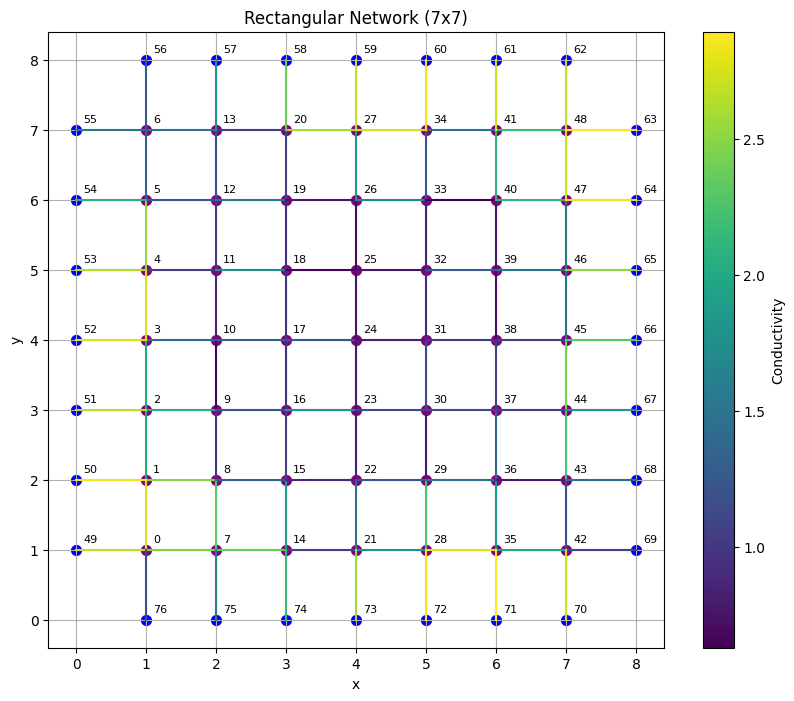

In [10]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_adaptive(
    num_epochs, dataloader, model, alpha, learning_rate, grid,
    min_lr=1e-14, eta_max=0.08, beta1=0.9, beta2=0.999, eps=1e-8,
    patience=1.5*cycle_length, init_delta_thresh=1e-4, cycle_length=cycle_length
)

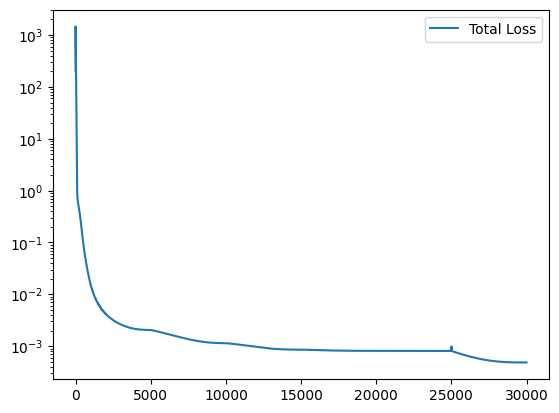

In [12]:
plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

It seems that the loss stalls at 1e-4. It is necessary to fine tune it more to attain smaller losses. Some ideas:
- store the parameter values for the best loss
- reduce the min_lr but increase the cycle length


In [11]:
torch.manual_seed(42)
n = 7
num_epochs = 30000
batch_size = 32
learning_rate = 0.02
alpha = 0.7
cycle_length = 10000

grid = GridStructure(n)
batch_size = min(4*n, batch_size)
data = generate_dtn_data(grid, batch_size)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid)

Epoch [1000/30000], Total Loss: 1.483480e-02, Interior: 3.118335e-03, Boundary: 1.171647e-02, Alpha: 0.7000, LR: 1.951154e-02, Best LR: 1.951154e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 10000, Delta Thresh: 1.000000e-06, Beta1: 0.9000, Beta2: 0.9990
Epoch [2000/30000], Total Loss: 3.778741e-03, Interior: 1.026957e-03, Boundary: 2.751783e-03, Alpha: 0.7000, LR: 1.809202e-02, Best LR: 1.810124e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 10000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [3000/30000], Total Loss: 2.297609e-03, Interior: 8.303877e-04, Boundary: 1.467222e-03, Alpha: 0.7000, LR: 1.588039e-02, Best LR: 1.589817e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 10000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9990
Epoch [4000/30000], Total Loss: 1.342277e-03, Interior: 4.348606e-04, Boundary: 9.074168e-04, Alpha: 0.7000, LR: 1.309316e-02, Best LR: 1.311406e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 10000, Delta Thresh: 1.000000e-07, Beta1: 0.9000

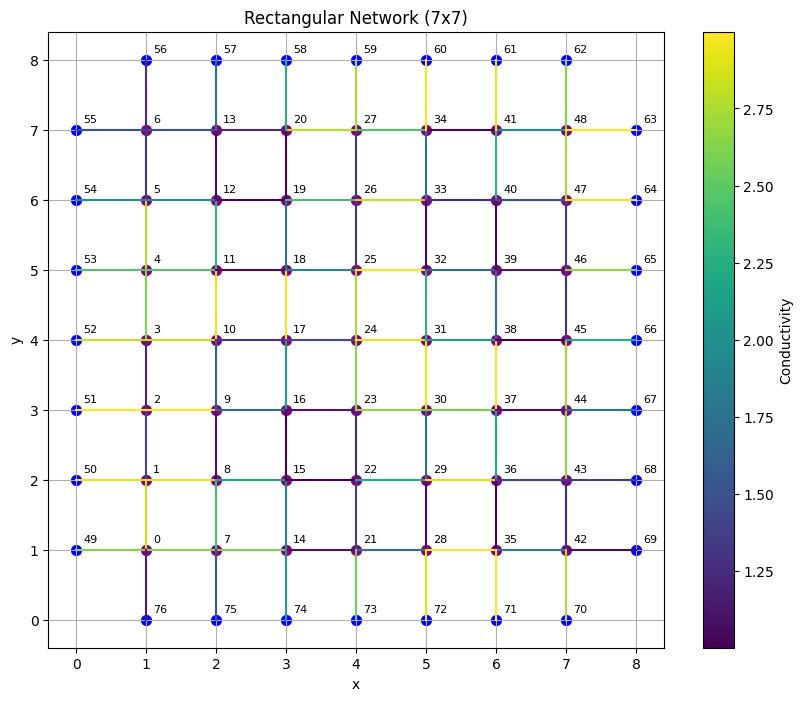

Recovered Conductivity


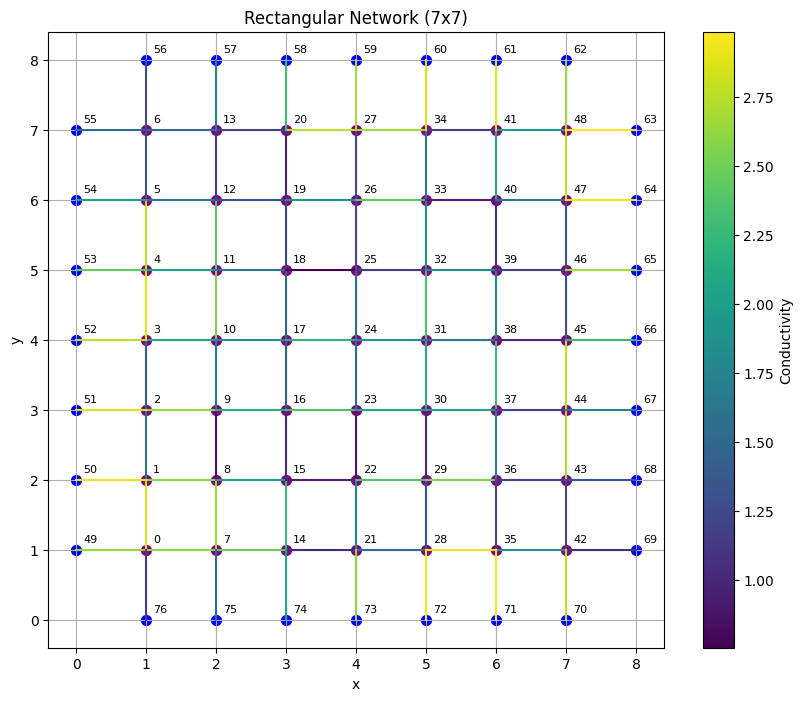

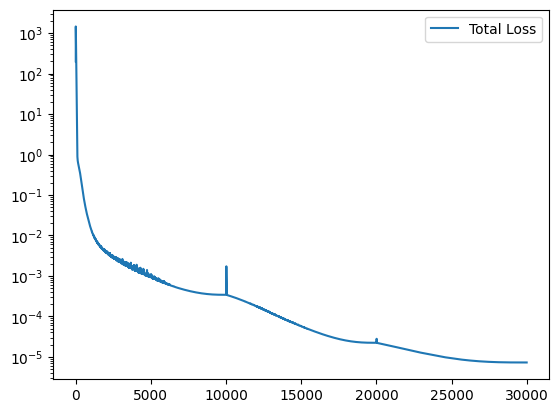

In [12]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_adaptive(
    num_epochs, dataloader, model, alpha, learning_rate, grid,
    min_lr=1e-14, eta_max=0.06, beta1=0.9, beta2=0.999, eps=1e-8,
    patience=1.5*cycle_length, init_delta_thresh=1e-4, cycle_length=cycle_length
)
plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()